In [1]:
import pandas as pd

# Load the dataset from the GitHub repository
url = 'https://raw.githubusercontent.com/gregversteeg/LinearCorex/master/tests/data/test_big5.csv'
df = pd.read_csv(url)

# Display basic information about the dataset
print("Number of instances in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display additional information
print("\nData Types and Non-Null Counts:")
print(df.info())

Number of instances in the dataset: 2000
Number of columns in the dataset: 50

First 5 rows of the dataset:
   blue_q0  red_q1  green_q2  purple_q3  q4  blue_q5  red_q6  green_q7  \
0        2       0         3          1   4        1       4         1   
1        2       0         1          2   2        1       4         3   
2        3       0         2          1   3        1       4         3   
3        2       0         1          1   1        0       4         1   
4        2       0         1          1   3        0       4         3   

   purple_q8  q9  ...  blue_q40  red_q41  green_q42  purple_q43  q44  \
0          2   2  ...         3        3          3           2    3   
1          3   1  ...         2        3          2           2    3   
2          3   0  ...         4        4          2           1    4   
3          3   1  ...         1        2          2           1    3   
4          2   0  ...         3        4          1           3    4   

   blue_q45  r

In [2]:
df = df / 4.0
# print(df.head())

In [3]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler

# Set the random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Convert the DataFrame to a NumPy array
data_array = df.to_numpy()

# Convert the data to a PyTorch tensor
data_tensor = torch.tensor(data_array, dtype=torch.float32)

# Create a PyTorch dataset
dataset = TensorDataset(data_tensor)

# Create a generator for deterministic splitting and sampling
generator = torch.Generator()
generator.manual_seed(seed)

# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Create a RandomSampler with the same generator for deterministic shuffling
train_sampler = RandomSampler(train_dataset, generator=generator)

# Create DataLoaders for the training and validation sets
batch_size = 32  # Adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Display the shape of the tensor to verify
print(f"Data tensor shape: {data_tensor.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Data tensor shape: torch.Size([2000, 50])
Number of training batches: 50
Number of validation batches: 13


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder class with explicit layer definitions and assert statements
class Encoder(nn.Module):
    def __init__(self, input_dim=50, hidden_dims=[128, 64], output_dim=5, embedding_dim=64):
        super(Encoder, self).__init__()

        # Assertions for input dimensions
        assert input_dim == 50, f"Expected input_dim to be 50, but got {input_dim}"
        assert output_dim == 5, f"Expected output_dim to be 5, but got {output_dim}"
        assert embedding_dim == 64, f"Expected embedding_dim to be 64, but got {embedding_dim}"

        # Define the layers explicitly
        self.layers = nn.ModuleList()
        dims = [input_dim] + hidden_dims + [output_dim]

        # Create Linear layers
        for i in range(len(dims) - 1):
            in_features = dims[i]
            out_features = dims[i + 1]
            layer = nn.Linear(in_features, out_features)
            self.layers.append(layer)

        # Learnable embedding vectors e_i for each z_i
        self.e = nn.Parameter(torch.randn(output_dim, embedding_dim))
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim

        # Assert the number of Linear layers
        expected_num_linear_layers = len(hidden_dims) + 1  # Number of hidden layers + output layer
        actual_num_linear_layers = len(self.layers)
        assert actual_num_linear_layers == expected_num_linear_layers, \
            f"Expected {expected_num_linear_layers} Linear layers, but got {actual_num_linear_layers}"

        # Assert the input and output dimensions of the Linear layers
        # First Linear layer
        first_linear = self.layers[0]
        assert first_linear.in_features == 50, \
            f"Expected first Linear layer to have input features 50, but got {first_linear.in_features}"

        # Last Linear layer
        last_linear = self.layers[-1]
        assert last_linear.out_features == 5, \
            f"Expected last Linear layer to have output features 5, but got {last_linear.out_features}"

        # Assert the shape of e
        assert self.e.shape == (5, 64), \
            f"Expected embedding matrix e to have shape (5, 64), but got {self.e.shape}"

    def forward(self, x):
        # Assert the input shape
        assert x.dim() == 2, f"Expected input x to be a 2D tensor, but got {x.dim()}D tensor"
        assert x.shape[1] == 50, f"Expected input x to have 50 features, but got {x.shape[1]}"

        batch_size = x.size(0)

        # Pass the input through the Linear layers with ReLU activations
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # Apply ReLU after each hidden layer except the last layer
            if i < len(self.layers) - 1:
                x = F.relu(x)

        Z = x  # Shape: (batch_size, output_dim)

        # Assert the shape of Z
        assert Z.shape == (batch_size, 5), \
            f"Expected Z to have shape ({batch_size}, 5), but got {Z.shape}"

        # Convert Z to \hat Z by multiplying each scalar z_i with its own embedding vector e_i
        Z_expanded = Z.unsqueeze(2)  # Shape: (batch_size, output_dim, 1)
        assert Z_expanded.shape == (batch_size, 5, 1), \
            f"Expected Z_expanded to have shape ({batch_size}, 5, 1), but got {Z_expanded.shape}"

        e_expanded = self.e.unsqueeze(0)  # Shape: (1, output_dim, embedding_dim)
        assert e_expanded.shape == (1, 5, 64), \
            f"Expected e_expanded to have shape (1, 5, 64), but got {e_expanded.shape}"

        # Multiply Z_expanded and e_expanded to get hat_Z
        hat_Z = Z_expanded * e_expanded  # Shape: (batch_size, output_dim, embedding_dim)
        assert hat_Z.shape == (batch_size, 5, 64), \
            f"Expected hat_Z to have shape ({batch_size}, 5, 64), but got {hat_Z.shape}"

        return hat_Z

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, input_dim=50, embedding_dim=64, hidden_dims=[]):
        super(Decoder, self).__init__()
        self.input_dim = input_dim      # Number of observed variables (n)
        self.embedding_dim = embedding_dim

        # Assert input dimensions
        assert input_dim == 50, f"Expected input_dim to be 50, but got {input_dim}"
        assert embedding_dim == 64, f"Expected embedding_dim to be 64, but got {embedding_dim}"

        # Learnable query embeddings (e1, e2, ..., en)
        self.query_embeddings = nn.Parameter(torch.randn(input_dim, embedding_dim))

        # Assert query_embeddings shape
        assert self.query_embeddings.shape == (50, 64), \
            f"Expected query_embeddings to have shape (50, 64), but got {self.query_embeddings.shape}"

        # MultiheadAttention module with 1 head
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=1, batch_first=True)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(embedding_dim)

        # Define individual MLPs for each observed variable
        dims = [embedding_dim] + hidden_dims + [1]

        # Create MLPs for each observed variable
        self.mlp_layers = nn.ModuleList([
            nn.Sequential(*[
                nn.Linear(dims[i], dims[i + 1]) if i == len(dims) - 2 else nn.Sequential(
                    nn.Linear(dims[i], dims[i + 1]),
                    nn.ReLU()
                )
                for i in range(len(dims) - 1)
            ])
            for _ in range(input_dim)
        ])

        # Assert that we have one MLP per observed variable
        assert len(self.mlp_layers) == 50, \
            f"Expected 50 MLPs in mlp_layers, but got {len(self.mlp_layers)}"

        # Verify that MLPs do not share parameters
        mlp_params = [set(mlp.parameters()) for mlp in self.mlp_layers]
        for i in range(len(mlp_params)):
            for j in range(i + 1, len(mlp_params)):
                assert mlp_params[i].isdisjoint(mlp_params[j]), \
                    f"MLP {i} and MLP {j} share parameters"

    def forward(self, hat_Z):
        """
        hat_Z: Tensor of shape (batch_size, output_dim, embedding_dim)
        """
        # Assert the shape of hat_Z
        assert hat_Z.dim() == 3, f"Expected hat_Z to be a 3D tensor, but got {hat_Z.dim()}D tensor"
        batch_size, output_dim, embedding_dim = hat_Z.shape
        assert embedding_dim == 64, \
            f"Expected hat_Z embedding_dim to be 64, but got {embedding_dim}"
        assert output_dim == 5, \
            f"Expected hat_Z output_dim to be 5, but got {output_dim}"

        # Prepare query embeddings and expand to batch size
        query_embeddings = self.query_embeddings.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: (batch_size, input_dim, embedding_dim)
        assert query_embeddings.shape == (batch_size, 50, 64), \
            f"Expected query_embeddings to have shape ({batch_size}, 50, 64), but got {query_embeddings.shape}"

        # Apply scaled dot-product attention
        attn_output, attn_weights = self.attention(query_embeddings, hat_Z, hat_Z)  # Output shape: (batch_size, input_dim, embedding_dim)
        assert attn_output.shape == (batch_size, 50, 64), \
            f"Expected attn_output to have shape ({batch_size}, 50, 64), but got {attn_output.shape}"
        assert attn_weights.shape == (batch_size, 50, 5), \
            f"Expected attn_weights to have shape ({batch_size}, 50, 5), but got {attn_weights.shape}"

        # Add residual connection and apply layer normalization
        out = self.layer_norm(attn_output + query_embeddings)  # Shape: (batch_size, input_dim, embedding_dim)
        assert out.shape == (batch_size, 50, 64), \
            f"Expected out to have shape ({batch_size}, 50, 64), but got {out.shape}"

        # Pass each context vector through its corresponding MLP
        x_hat = []
        for i in range(self.input_dim):
            x_i = out[:, i, :]  # Shape: (batch_size, embedding_dim)
            assert x_i.shape == (batch_size, 64), \
                f"Expected x_i to have shape ({batch_size}, 64), but got {x_i.shape}"

            x_i_hat = self.mlp_layers[i](x_i)  # Shape: (batch_size, 1)
            assert x_i_hat.shape == (batch_size, 1), \
                f"Expected x_i_hat to have shape ({batch_size}, 1), but got {x_i_hat.shape}"

            x_hat.append(x_i_hat)
        x_hat = torch.cat(x_hat, dim=1)  # Shape: (batch_size, input_dim)
        assert x_hat.shape == (batch_size, 50), \
            f"Expected x_hat to have shape ({batch_size}, 50), but got {x_hat.shape}"

        return x_hat, attn_weights  # Return attention weights

In [6]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, encoder_hidden_dims=[], decoder_hidden_dims=[]):
        super(Model, self).__init__()
        self.encoder = Encoder(
            input_dim=input_dim,
            output_dim=output_dim,
            embedding_dim=embedding_dim,
            hidden_dims=encoder_hidden_dims
        )
        self.decoder = Decoder(
            input_dim=input_dim,
            embedding_dim=embedding_dim,
            hidden_dims=decoder_hidden_dims
        )

    def forward(self, x):
        hat_Z = self.encoder(x)     # Obtain \hat{Z} from the encoder
        x_hat, attn_weights = self.decoder(hat_Z)  # Reconstruct x from \hat{Z} using the decoder
        return x_hat, attn_weights


In [7]:
import os
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Assuming 'df' is your original dataframe

# Identify column prefixes for each true factor
factor_columns = {
    'Factor1': [col for col in df.columns if col.startswith('blue')],
    'Factor2': [col for col in df.columns if col.startswith('green')],
    'Factor3': [col for col in df.columns if col.startswith('purple')],
    'Factor4': [col for col in df.columns if col.startswith('red')],
    'Factor5': [col for col in df.columns if col.startswith('q')]
}

# Map factor names to column indices
factor_indices = {}
for factor_name, columns in factor_columns.items():
    indices = [df.columns.get_loc(col) for col in columns]
    factor_indices[factor_name] = indices

# Create true_labels based on the factor_indices
input_dim = len(df.columns)
true_labels = np.full(input_dim, -1, dtype=int)  # Initialize with -1

# Map factor names to indices
factor_names = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5']
factor_name_to_index = {name: idx for idx, name in enumerate(factor_names)}

# Assign labels to observed variables based on factors
for factor_name, indices in factor_indices.items():
    factor_idx = factor_name_to_index[factor_name]
    true_labels[indices] = factor_idx

# Ensure all observed variables have been assigned
assert np.all(true_labels >= 0), "Some observed variables have not been assigned a true label"

# Define dimensions
input_dim = len(df.columns)  # Number of observed variables
output_dim = 5               # Output dimension of the encoder (number of factors)
embedding_dim = 64           # Embedding dimension for the embeddings e and e_i's
encoder_hidden_dims = [128, 64]  # Hidden dimensions for the encoder
decoder_hidden_dims = [64, 32]   # Hidden dimensions for the decoder

# Instantiate the model
model = Model(
    input_dim=input_dim,
    output_dim=output_dim,
    embedding_dim=embedding_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=decoder_hidden_dims
)

# Move the model to the appropriate device (GPU if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 25          # Number of epochs
batch_size = 32          # Batch size (already set in the DataLoader)
print_every = 1          # How often to print loss (in epochs)

# Define the maximum value for the entropy regularization coefficient
max_lambda_entropy = 0.4*1e-2  # Adjust this value as needed

# Flag to enable or disable entropy regularizer
use_entropy_regularizer = True # Set to True to enable, False to disable

def get_lambda_entropy(epoch, num_epochs, max_lambda_entropy, schedule_type='exponential', use_entropy_regularizer=True):
    if not use_entropy_regularizer:
        return 0.0
    if schedule_type == 'constant':
        # Always return max_lambda_entropy
        return max_lambda_entropy
    elif schedule_type == 'linear':
        # Linear increase from 0 to max_lambda_entropy
        return max_lambda_entropy * (epoch / num_epochs)
    elif schedule_type == 'exponential':
        # Exponential increase from 0 to max_lambda_entropy
        k = 5  # Adjust this value to control the rate of increase
        numerator = math.exp(k * epoch / num_epochs) - 1
        denominator = math.exp(k) - 1
        return max_lambda_entropy * (numerator / denominator)
    elif schedule_type == 'logarithmic':
        # Logarithmic increase from 0 to max_lambda_entropy
        if epoch == 0:
            return 0.0
        else:
            return max_lambda_entropy * math.log(epoch + 1) / math.log(num_epochs + 1)
    else:
        raise ValueError(f"Unknown schedule_type: {schedule_type}")

# Define a function to compute ARI between true and predicted groupings
def compute_ari_per_sample(true_labels, predicted_labels):
    """
    Computes the ARI between true_labels and predicted_labels.
    Both true_labels and predicted_labels should be 1D arrays of the same length.
    """
    assert true_labels.shape == predicted_labels.shape, f"Shapes of true_labels {true_labels.shape} and predicted_labels {predicted_labels.shape} do not match"
    ari = adjusted_rand_score(true_labels, predicted_labels)
    return ari

# Load the trained model if it exists
model_path = "trained_model.pth"
if os.path.exists(model_path):
    print("Trained model found. Loading the model.")
    checkpoint = torch.load(model_path, map_location=device)
    # Since we saved the state_dict directly, we can load it directly
    model.load_state_dict(checkpoint)
    print("Model loaded successfully!")
else:
    print("No trained model found. Starting training from scratch.")

# Initialize a list to store the average attention matrices per epoch
attention_matrices = []

# More interpretable entropy normalization
ent_norm = 1.0 / (input_dim * math.log(output_dim))

# Initialize lists to store ARIs
train_ari_list = []
val_ari_list = []

# Training loop with validation
for epoch in range(num_epochs):
    # Compute lambda_entropy for the current epoch
    lambda_entropy = get_lambda_entropy(
        epoch, num_epochs, max_lambda_entropy, schedule_type='exponential', use_entropy_regularizer=use_entropy_regularizer)

    # Assert that lambda_entropy is within expected bounds
    assert lambda_entropy >= 0.0, f"Lambda entropy should be non-negative, got {lambda_entropy}"
    assert lambda_entropy <= max_lambda_entropy, f"Lambda entropy should not exceed max_lambda_entropy ({max_lambda_entropy}), got {lambda_entropy}"

    # Training phase
    model.train()
    running_loss = 0.0          # Accumulates total loss (reconstruction + regularizer)
    running_recon_loss = 0.0    # Accumulates reconstruction loss
    running_entropy_loss = 0.0  # Accumulates entropy loss
    epoch_attn_weights = []     # List to store attention weights for all batches in the epoch
    epoch_ari = []              # List to store average ARI per batch

    for batch_idx, (batch,) in enumerate(train_loader):
        batch = batch.to(device)

        # Assert that batch has expected shape
        batch_size = batch.size(0)
        assert batch.dim() == 2, f"Expected batch to be a 2D tensor, got {batch.dim()}D tensor"
        assert batch.shape[1] == input_dim, f"Expected batch to have {input_dim} features, got {batch.shape[1]}"

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted x_hat and attention weights
        x_hat, attn_weights = model(batch)

        # Assert shapes of x_hat and attn_weights
        assert x_hat.shape == (batch_size, input_dim), f"Expected x_hat shape ({batch_size}, {input_dim}), got {x_hat.shape}"
        assert attn_weights.dim() == 3, f"Expected attn_weights to be 3D tensor, got {attn_weights.dim()}D tensor"
        assert attn_weights.shape == (batch_size, input_dim, output_dim), f"Expected attn_weights shape ({batch_size}, {input_dim}, {output_dim}), got {attn_weights.shape}"

        # No need to squeeze attn_weights since it's already 3D
        # Collect attention weights for the epoch
        epoch_attn_weights.append(attn_weights.detach().cpu())

        # Compute the reconstruction loss
        recon_loss = criterion(x_hat, batch)

        # Assert that recon_loss is a scalar
        assert recon_loss.dim() == 0, f"Expected recon_loss to be a scalar, got tensor with shape {recon_loss.shape}"

        # Initialize entropy_regularizer to zero
        entropy_regularizer = 0.0

        # Add a small epsilon to prevent log(0)
        epsilon = 1e-8

        # Compute entropy for each query (input_dim)
        entropy = -torch.sum(attn_weights * torch.log(attn_weights + epsilon), dim=2)  # Shape: (batch_size, input_dim)

        # Assert entropy shape
        assert entropy.shape == (batch_size, input_dim), f"Expected entropy shape ({batch_size}, {input_dim}), got {entropy.shape}"

        # Sum entropies over queries and average over batch
        entropy_regularizer = ent_norm * torch.mean(torch.sum(entropy, dim=1))  # Scalar

        # Assert that entropy_regularizer is scalar
        assert entropy_regularizer.dim() == 0, f"Expected entropy_regularizer to be a scalar, got tensor with shape {entropy_regularizer.shape}"

        # Total loss
        loss = recon_loss + lambda_entropy * entropy_regularizer

        # Assert that loss is scalar
        assert loss.dim() == 0, f"Expected loss to be a scalar, got tensor with shape {loss.shape}"

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training losses
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_entropy_loss += entropy_regularizer.item()  # Accumulate entropy regularizer loss

        # Compute ARI per sample and average over batch
        attn_weights_np = attn_weights.detach().cpu().numpy()  # Shape: (batch_size, input_dim, output_dim)
        batch_ari = []
        for i in range(batch_size):
            # For each sample in the batch
            predicted_labels = np.argmax(attn_weights_np[i], axis=1)  # Shape: (input_dim,)
            # Compute ARI between true_labels and predicted_labels
            ari = compute_ari_per_sample(true_labels, predicted_labels)
            batch_ari.append(ari)
        # Average ARI over batch
        avg_ari_batch = np.mean(batch_ari)
        epoch_ari.append(avg_ari_batch)

    # Compute average losses and ARI for training
    avg_train_loss = running_loss / len(train_loader)
    avg_train_recon_loss = running_recon_loss / len(train_loader)
    avg_train_entropy_loss = running_entropy_loss / len(train_loader)
    avg_train_ari = np.mean(epoch_ari)
    train_ari_list.append(avg_train_ari)

    # Compute the average attention matrix for the epoch
    epoch_attn_weights_tensor = torch.cat(epoch_attn_weights, dim=0)  # Shape: (num_samples_in_epoch, input_dim, output_dim)

    # Assert shape of epoch_attn_weights_tensor
    num_samples_in_epoch = epoch_attn_weights_tensor.size(0)
    assert epoch_attn_weights_tensor.shape == (num_samples_in_epoch, input_dim, output_dim), f"Expected epoch_attn_weights_tensor shape ({num_samples_in_epoch}, {input_dim}, {output_dim}), got {epoch_attn_weights_tensor.shape}"

    avg_attn_weights_epoch = epoch_attn_weights_tensor.mean(dim=0)    # Shape: (input_dim, output_dim)

    # Assert shape of avg_attn_weights_epoch
    assert avg_attn_weights_epoch.shape == (input_dim, output_dim), f"Expected avg_attn_weights_epoch shape ({input_dim}, {output_dim}), got {avg_attn_weights_epoch.shape}"

    avg_attn_weights_epoch_np = avg_attn_weights_epoch.numpy()

    # Transpose to have shape (output_dim, input_dim) so that queries are on x-axis and keys on y-axis
    attention_matrices.append(avg_attn_weights_epoch_np.T)

    # Validation phase
    model.eval()
    val_loss = 0.0          # Accumulates total loss (reconstruction + regularizer)
    val_recon_loss = 0.0    # Accumulates reconstruction loss
    val_entropy_loss = 0.0  # Accumulates entropy regularizer loss
    epoch_attn_weights_val = []
    epoch_ari_val = []

    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(val_loader):
            batch = batch.to(device)

            # Assert that batch has expected shape
            batch_size = batch.size(0)
            assert batch.dim() == 2, f"Expected batch to be a 2D tensor, got {batch.dim()}D tensor"
            assert batch.shape[1] == input_dim, f"Expected batch to have {input_dim} features, got {batch.shape[1]}"

            # Forward pass for validation
            x_hat, attn_weights = model(batch)

            # Assert shapes of x_hat and attn_weights
            assert x_hat.shape == (batch_size, input_dim), f"Expected x_hat shape ({batch_size}, {input_dim}), got {x_hat.shape}"
            assert attn_weights.dim() == 3, f"Expected attn_weights to be 3D tensor, got {attn_weights.dim()}D tensor"
            assert attn_weights.shape == (batch_size, input_dim, output_dim), f"Expected attn_weights shape ({batch_size}, {input_dim}, {output_dim}), got {attn_weights.shape}"

            # Collect attention weights for validation
            epoch_attn_weights_val.append(attn_weights.detach().cpu())

            # Compute the reconstruction loss
            recon_loss = criterion(x_hat, batch)

            # Assert that recon_loss is a scalar
            assert recon_loss.dim() == 0, f"Expected recon_loss to be a scalar, got tensor with shape {recon_loss.shape}"

            # Initialize entropy_regularizer to zero
            entropy_regularizer = 0.0

            # Add a small epsilon to prevent log(0)
            epsilon = 1e-8

            # Compute entropy for each query (input_dim)
            entropy = -torch.sum(attn_weights * torch.log(attn_weights + epsilon), dim=2)  # Shape: (batch_size, input_dim)

            # Assert entropy shape
            assert entropy.shape == (batch_size, input_dim), f"Expected entropy shape ({batch_size}, {input_dim}), got {entropy.shape}"

            # Sum entropies over queries and average over batch
            entropy_regularizer = ent_norm * torch.mean(torch.sum(entropy, dim=1))  # Scalar

            # Assert that entropy_regularizer is scalar
            assert entropy_regularizer.dim() == 0, f"Expected entropy_regularizer to be a scalar, got tensor with shape {entropy_regularizer.shape}"

            # Total loss
            loss = recon_loss + lambda_entropy * entropy_regularizer

            # Assert that loss is scalar
            assert loss.dim() == 0, f"Expected loss to be a scalar, got tensor with shape {loss.shape}"

            # Accumulate validation losses
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_entropy_loss += entropy_regularizer.item()  # Accumulate entropy regularizer loss

            # Compute ARI per sample and average over batch
            attn_weights_np = attn_weights.detach().cpu().numpy()  # Shape: (batch_size, input_dim, output_dim)
            batch_ari = []
            for i in range(batch_size):
                # For each sample in the batch
                predicted_labels = np.argmax(attn_weights_np[i], axis=1)  # Shape: (input_dim,)
                # Compute ARI between true_labels and predicted_labels
                ari = compute_ari_per_sample(true_labels, predicted_labels)
                batch_ari.append(ari)
            # Average ARI over batch
            avg_ari_batch = np.mean(batch_ari)
            epoch_ari_val.append(avg_ari_batch)

        # Compute average losses and ARI for validation
        avg_val_loss = val_loss / len(val_loader)
        avg_val_recon_loss = val_recon_loss / len(val_loader)
        avg_val_entropy_loss = val_entropy_loss / len(val_loader)
        avg_val_ari = np.mean(epoch_ari_val)
        val_ari_list.append(avg_val_ari)

    # Print average losses and ARI for the epoch
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Lambda Entropy: {lambda_entropy:.6f}, '
              f'Train Total Loss: {avg_train_loss:.4f}, Train Recon Loss: {avg_train_recon_loss:.4f}, Train Entropy Loss: {avg_train_entropy_loss:.4f}, Train ARI: {avg_train_ari:.4f}, '
              f'Val Total Loss: {avg_val_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}, Val Entropy Loss: {avg_val_entropy_loss:.4f}, Val ARI: {avg_val_ari:.4f}')

# Save the trained model after training
# torch.save(model.state_dict(), "trained_model.pth")
# print("Training complete and model saved.")

Using device: mps
No trained model found. Starting training from scratch.
Epoch [1/25], Lambda Entropy: 0.000000, Train Total Loss: 0.1244, Train Recon Loss: 0.1244, Train Entropy Loss: 0.9415, Train ARI: -0.0046, Val Total Loss: 0.0846, Val Recon Loss: 0.0846, Val Entropy Loss: 0.8934, Val ARI: 0.0135
Epoch [2/25], Lambda Entropy: 0.000006, Train Total Loss: 0.0783, Train Recon Loss: 0.0783, Train Entropy Loss: 0.7880, Train ARI: 0.0280, Val Total Loss: 0.0719, Val Recon Loss: 0.0719, Val Entropy Loss: 0.7658, Val ARI: 0.0542
Epoch [3/25], Lambda Entropy: 0.000013, Train Total Loss: 0.0688, Train Recon Loss: 0.0688, Train Entropy Loss: 0.7718, Train ARI: 0.0941, Val Total Loss: 0.0635, Val Recon Loss: 0.0635, Val Entropy Loss: 0.7481, Val ARI: 0.1454
Epoch [4/25], Lambda Entropy: 0.000022, Train Total Loss: 0.0616, Train Recon Loss: 0.0616, Train Entropy Loss: 0.7645, Train ARI: 0.1740, Val Total Loss: 0.0589, Val Recon Loss: 0.0589, Val Entropy Loss: 0.7876, Val ARI: 0.2105
Epoch [5/

In [8]:
# import numpy as np
# import torch
# import torch.nn as nn
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML, display
# import seaborn as sns
# from sklearn.metrics import adjusted_rand_score

# # Assuming 'df' is your original dataframe

# # Identify column prefixes for each true factor
# factor_columns = {
#     'Factor1': [col for col in df.columns if col.startswith('blue')],
#     'Factor2': [col for col in df.columns if col.startswith('green')],
#     'Factor3': [col for col in df.columns if col.startswith('purple')],
#     'Factor4': [col for col in df.columns if col.startswith('red')],
#     'Factor5': [col for col in df.columns if col.startswith('q')]
# }

# # Map factor names to column indices
# factor_indices = {}
# for factor_name, columns in factor_columns.items():
#     indices = [df.columns.get_loc(col) for col in columns]
#     factor_indices[factor_name] = indices

# Create a new ordering of indices
new_order = []
for factor_name in factor_columns.keys():
    new_order.extend(factor_indices[factor_name])

# Ensure all indices are included
assert len(new_order) == df.shape[1], "Not all indices are included in the new order."

In [9]:
# # Rearranging attention matrices for the animation
# reordered_attention_matrices = []

# for attn_matrix in attention_matrices:
#     # attn_matrix has shape (output_dim, input_dim)
#     # Rearrange the columns (observed variables) according to new_order
#     attn_matrix_reordered = attn_matrix[:, new_order]  # Shape: (output_dim, input_dim)
#     reordered_attention_matrices.append(attn_matrix_reordered)

# # Convert the list to a NumPy array for animation
# attention_matrices_array = np.stack(reordered_attention_matrices)  # Shape: (num_epochs, output_dim, input_dim)

# # Determine the number of frames (epochs)
# num_frames = attention_matrices_array.shape[0]

# # Set up the figure and axis for the animation
# fig, ax = plt.subplots(figsize=(10, 6))

# # Initialize the heatmap with empty data
# im = ax.imshow(np.zeros_like(attention_matrices_array[0]), aspect='auto', cmap='viridis', vmin=0, vmax=1)
# ax.set_xlabel('Observed Variables')
# ax.set_ylabel('Latent Factors')
# title = ax.set_title('Attention Matrix at Epoch 1')

# # Function to initialize the heatmap
# def init():
#     data = attention_matrices_array[0]
#     im.set_data(data)
#     title.set_text('Attention Matrix at Epoch 1')
#     return [im, title]

# # Function to update the heatmap for each frame
# def update(frame):
#     data = attention_matrices_array[frame]
#     im.set_data(data)
#     title.set_text(f'Attention Matrix at Epoch {frame + 1}')
#     return [im, title]

# # Create the animation
# ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True)

# # Close the figure to prevent the static plot from displaying
# plt.close(fig)

# # Display the animation in the notebook
# display(HTML(ani.to_jshtml()))

# # Save the animation to an MP4 file (optional)
# # ani.save('attention_animation.mp4', writer='ffmpeg', fps=2)

In [10]:
# Compute average attention matrices (assuming you have 'model', 'train_loader', and 'val_loader')
def compute_average_attention(model, dataloader, device):
    model.eval()  # Ensure model is in evaluation mode
    total_attn = None
    num_samples = 0

    with torch.no_grad():
        for data in dataloader:
            inputs = data[0].to(device)

            # Forward pass up to obtaining attention weights
            hat_Z = model.encoder(inputs)
            _, attn_weights = model.decoder(hat_Z)

            # attn_weights shape: (batch_size, input_dim, output_dim)
            batch_size = attn_weights.size(0)
            if total_attn is None:
                total_attn = attn_weights.sum(dim=0)  # Sum over batch dimension
            else:
                total_attn += attn_weights.sum(dim=0)
            num_samples += batch_size

    # Average the attention weights
    avg_attn = total_attn / num_samples

    return avg_attn.cpu().numpy()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Compute average attention matrices
avg_attn_train = compute_average_attention(model, train_loader, device)
avg_attn_val = compute_average_attention(model, val_loader, device)

In [11]:
# Calculating ARI
input_dim = avg_attn_train.shape[0]   # Number of observed variables
output_dim = avg_attn_train.shape[1]  # Number of latent factors

# Step 1: Assign each observed variable to the latent factor with the highest attention weight
predicted_labels = np.argmax(avg_attn_train, axis=1)  # Shape: (input_dim,)

# Step 2: Create true labels based on ideal groups
true_labels = np.full(input_dim, -1)  # Initialize with -1

# Map factor names to indices
factor_names = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5']
factor_name_to_index = {name: idx for idx, name in enumerate(factor_names)}

# Assign labels to observed variables based on factors
for factor_name, indices in factor_indices.items():
    factor_idx = factor_name_to_index[factor_name]
    true_labels[indices] = factor_idx

# Ensure all observed variables have been assigned
assert np.all(true_labels >= 0), "Some observed variables have not been assigned a true label"

# Step 3: Compute Adjusted Rand Index
ari = adjusted_rand_score(true_labels, predicted_labels)

print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.5811047786058746


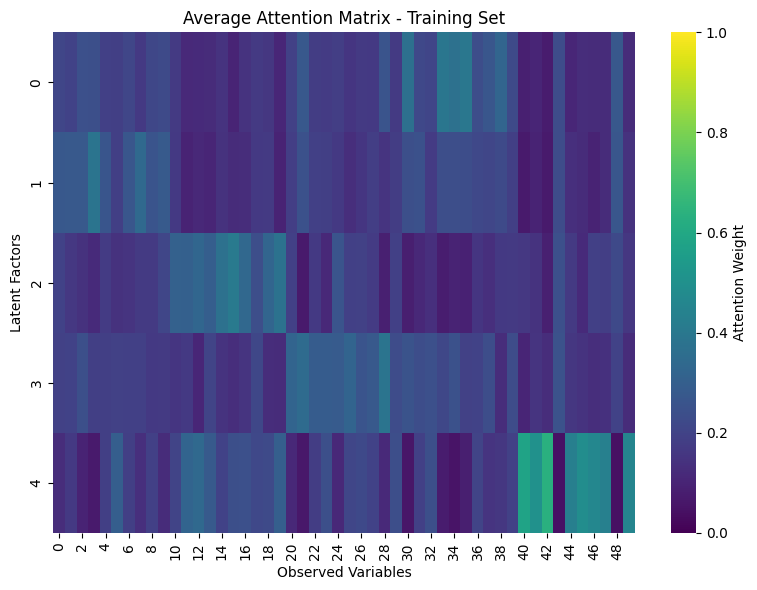

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

# Transpose the average attention matrices
avg_attn_train_transposed = avg_attn_train.T  # Shape: (output_dim, input_dim)
avg_attn_val_transposed = avg_attn_val.T      # Shape: (output_dim, input_dim)

# Rearrange the columns (observed variables) using new_order
avg_attn_train_reordered = avg_attn_train_transposed[:, new_order]
avg_attn_val_reordered = avg_attn_val_transposed[:, new_order]

def plot_attention_heatmap(attn_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        attn_matrix,
        cmap='viridis',
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Attention Weight'}
    )
    plt.title(title)
    plt.xlabel('Observed Variables')
    plt.ylabel('Latent Factors')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot average attention matrices with fixed color scaling
plot_attention_heatmap(avg_attn_train_reordered, 'Average Attention Matrix - Training Set')